# Lab 07: Genetic Algorithms

## Total: 50 points

In this lab, you'll explore the fundamentals of genetic algorithms by implementing core operations like selection, crossover, and mutation. We give you the initialization code and fitness function so you can focus the different ways to implement core operations.

## General Instructions

- Carefully read through the commented helper functions.
- Implement the missing functions where marked with `pass`.
- This lab is VERY open ended! There isn't one way to do this. Implement the strategies or verisons that interest you!
- **We have provided suggested parameters to pass into the unimplemented functions, but depending on the methods you pick, the parameters might change or you will need additional ones. Make sure to edit the parameter list for methods and strategies you use!!** 

In [2]:
import random
import matplotlib.pyplot as plt
import time
import numpy as np

In [3]:
# Problem Constants
NUM_PEOPLE = 5
SHIFTS_PER_DAY = 3
DAYS_PER_WEEK = 7
SHIFTS_PER_WEEK = SHIFTS_PER_DAY * DAYS_PER_WEEK # 21

In [4]:
# GA Parameters
POPULATION_SIZE = 100       # Number of schedules in each generation
GENERATIONS = 150           # Number of generations to run
MUTATION_RATE = 0.02        # Probability of a single bit flip mutation
CROSSOVER_RATE = 0.7        # Probability that crossover occurs between two parents
HARD_PENALTY = -2           # Penalty per violated hard constraint
SOFT_PENALTY = -1           # Penalty per violated soft constraint

# Helper Functions

In [5]:
## Helper Functions
def get_shift_details(shift_index):
    """
    Calculates day (0-6) and shift type (0=M, 1=A, 2=N) from shift index (0-20).

    Args:
        shift_index (int): The shift index (0-20)

    Returns:
        day (int): The day of the week (0-6)
        shift_type (int): The shift type (0=M, 1=A, 2=N)
    """
    if not (0 <= shift_index < SHIFTS_PER_WEEK):
        raise ValueError(f"shift_index {shift_index} out of range [0, {SHIFTS_PER_WEEK-1}]")
    day = shift_index // SHIFTS_PER_DAY
    shift_type = shift_index % SHIFTS_PER_DAY
    return day, shift_type

def print_schedule(schedule, fitness):
    """
    Prints the schedule in a readable format.

    Args:
        schedule (list): The schedule to print
        fitness (float): The fitness score of the schedule
    """
    print(f"\nSchedule (Fitness: {fitness:.2f}):")
    days = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
    shifts = ["M", "A", "N"]
    header = "      " + " | ".join([days[d] for d in range(DAYS_PER_WEEK)])
    print(header)
    subheader = "      " + " ".join([f"{s}" for _ in days for s in shifts])
    print(subheader)
    print("      " + "-" * (len(subheader)-1))
    for person_idx, person_schedule in enumerate(schedule):
        schedule_str = ""
        for i in range(SHIFTS_PER_WEEK):
             schedule_str += str(person_schedule[i])
             if (i + 1) % SHIFTS_PER_DAY == 0 and i < SHIFTS_PER_WEEK - 1:
                 schedule_str += " " # Add space between days
        print(f"ATC {person_idx+1}: {schedule_str}")
    print("-" * (len(subheader) + 5))

def plot_fitness(fitness_history):
    """
    Plots the best and average fitness score per generation.

    Args:
        fitness_history (list): A list of fitness scores for each generation

    Returns:
        None
    """
    plt.figure(figsize=(12, 6))
    generations = range(1, len(fitness_history) + 1)
    plt.plot(generations, fitness_history, marker='o', linestyle='-', label='Best Fitness')
    plt.title('GA Fitness Progression for ATC Scheduling')
    plt.xlabel('Generation')
    plt.ylabel('Fitness Score (Higher is Better)')
    # Set y-limit to start slightly below the minimum fitness achieved or a reasonable lower bound
    min_fitness = min(fitness_history)
    plt.ylim(bottom=min(min_fitness - 5, -50)) # Adjust y-axis floor
    plt.legend()
    plt.grid(True)
    plt.show()

## Initialization

Helper code to create the initial population. Make sure you understand how we have chosen to represent the individual and population!

In [6]:
# Init GA
def generate_initial_representation(num_people, shifts_per_week):
  """
  Creates a single random schedule representation (chromosome).
  Each person gets a list of 0s and 1s for the week's shifts.

  Args:
    num_people (int): The number of people in the schedule.
    shifts_per_week (int): The number of shifts per week.

  Returns:
    schedule (list): A list of lists, where each inner list represents a person's schedule for the week.
  """
  schedule = []
  for _ in range(num_people):
    person_schedule = [random.choice([0, 1]) for _ in range(shifts_per_week)]
    schedule.append(person_schedule)
  return schedule

def generate_population(population_size, num_people, shifts_per_week):
  """ Creates the initial population of random schedules. """
  return [generate_initial_representation(num_people, shifts_per_week)
          for _ in range(population_size)]

## Fitness Function

Evaluate how close a candidate is to the target solution. Note how hard versus soft constraints are handled.

In [7]:
def evaluate_fitness(schedule, num_people, shifts_per_week, shifts_per_day):
    """ 
    Calculates the fitness of a single schedule based on constraints. 

    Args:
        schedule (list): The schedule to evaluate
        num_people (int): The number of people in the schedule
        shifts_per_week (int): The number of shifts per week
        shifts_per_day (int): The number of shifts per day

    Returns:
        fitness (float): The fitness score of the schedule
    """
    fitness = 0 # Start with perfect fitness, subtract penalties
    
    # Hard Constraint Checks

    # 1. Minimum controllers per shift
    min_controllers = {0: 1, 1: 2, 2: 1} # M:1, A:2, N:1
    shift_violations = 0
    for shift_idx in range(shifts_per_week):
        _, shift_type = get_shift_details(shift_idx)

        # Calculate number of controllers on this shift
        controllers_on_shift = sum(schedule[p][shift_idx] for p in range(num_people))
        required = min_controllers[shift_type]

        # Penalize for each missing controller
        if controllers_on_shift < required:
            fitness += HARD_PENALTY * (required - controllers_on_shift)
            shift_violations += (required - controllers_on_shift)

    # 2. Rest periods
    rest_violations = 0
    for p in range(num_people):
        for shift_idx in range(shifts_per_week):
            if schedule[p][shift_idx] == 1: # If person p works this shift
                _, shift_type = get_shift_details(shift_idx)

                # a) Rest after Morning (0) or Afternoon (1)
                if shift_type in [0, 1]:
                    next_shift_idx = shift_idx + 1
                    # Check boundary: ensure next shift is within the week
                    if next_shift_idx < shifts_per_week and schedule[p][next_shift_idx] == 1:
                         fitness += HARD_PENALTY # Violation: Working the very next shift
                         rest_violations += 1

                # b) Rest after Night (2)
                elif shift_type == 2:
                    # Check the next 3 shifts (full day)
                    violation_found_for_night_shift = False
                    for i in range(1, shifts_per_day + 1):
                        next_shift_idx = shift_idx + i
                        # Check boundary: ensure check stays within the week
                        if next_shift_idx < shifts_per_week and schedule[p][next_shift_idx] == 1:
                            if not violation_found_for_night_shift: # Only penalize once per night shift violation
                                fitness += HARD_PENALTY
                                rest_violations += 1
                                violation_found_for_night_shift = True
                            # No need to check further shifts for *this* night shift once violation is found

    # Soft Constraint Checks

    # 1. Excess controllers in tower
    excess_violations = 0
    for shift_idx in range(shifts_per_week):
        _, shift_type = get_shift_details(shift_idx)
        controllers_on_shift = sum(schedule[p][shift_idx] for p in range(num_people))
        required = min_controllers[shift_type]
        if controllers_on_shift > required:
            excess = controllers_on_shift - required
            fitness += SOFT_PENALTY * excess # Penalize for each extra controller
            excess_violations += excess

    # A fitness of 0 means no constraints were violated. Higher (less negative) is better.
    # You could also return the counts of violations for analysis if needed:
    # return fitness, shift_violations, rest_violations, excess_violations
    return fitness

## Q1.1 Parent Selection (4 points)

In this step, pick the parents chosen for crossover. Recall there are lots of different ways this can fit together with the crossover step. It's up to you on which method you pick.

In [ ]:
def parent_selection(population, fitness_scores, num_parents):
    """
    Use elitism to select the best two parents by fitness score and breed them for the next generation
    
    Args:
        population (list): list of schedules in our population
        finess_scores (list): list of fitness scores for each schedule in our population
        num_parents (int): how many parents to select
    """
    smallest = min(fitness_scores)
    shifted = np.array(fitness_scores) + smallest + 1e-6
    tot_fitness = np.sum(shifted)

    probabilities = shifted / tot_fitness

    parent_indices = np.random.choice(len(population), size=num_parents, replace=True, p=probabilities)
    selected_parents = np.array(population)[parent_indices]

    return selected_parents.tolist()

## Q1.2 Crossover (4 points)

In this step, you combine two (or more) parent chromosomes to produce an offspring (or more). Recall that you can use the CROSSOVER_RATE parameter.

In [9]:
def crossover(parent_1, parent_2, shifts_per_week, crossover_rate):
    """
    Creates two children based on two parents. Crossover may occur with the chance of
    the crossover rate param. If it does, one-point crossover will be applied at
    a random point.
    
    Args:
        parent_1 (list): parent schedule 1
        parent_2 (list): parent schedule 2
        shifts_per_week (int): number of shifts per week (to know where our crossover can happen)
        crossover_rate (float): the chance that a crossover will occur
    """
    child_1 = parent_1
    child_2 = parent_2
    if random.random() <= crossover_rate:
        crossover_point = random.randint(0, shifts_per_week-1)
        child_1_crossed = child_1[:crossover_point] + child_2[crossover_point:]
        child_2_crossed = child_2[:crossover_point] + child_1[crossover_point:]
        return child_1_crossed, child_2_crossed
    else:
        return child_1, child_2

## Q1.3 Mutation (4 points)

Add random mutations to chromosomes to maintain genetic diversity. You'll implement a function that randomly changes characters in the chromosome string. Recall that you can use the MUTATION_RATE parameter.

In [10]:
def mutate(schedule, mutation_rate):
    """
    Potentially mutates a given schedule - at each bit, there is a mutation_rate
    chance it gets flipped.

    Args:
        schedule (list): given schedule to mutate
        mutation_rate (float): the chance each bit gets flipped
    """
    for i, person in enumerate(schedule):
        for j, shift in enumerate(person):
            if random.random()<= mutation_rate:
                schedule[i][j] = 1 if shift == 0 else 0
    return schedule

## Q1.4 Selection (4 points)

You will implement a method for selecting parent chromosomes based on their fitness scores. The better the fitness, the higher the chance of selection.

In [11]:
def select_survivors(population, offspring_population, population_size, num_people, shifts_per_week, shifts_per_day, days_per_week):
    """
    Based on a current population

    make sure the parameters make sense for your chosen method!
    """
    pop_size = len(population)
    sorted_pop = sorted(population + offspring_population, key=lambda x: evaluate_fitness(x, num_people, shifts_per_week, shifts_per_day), reverse=True)
    return sorted_pop[:pop_size]
    

## Q1.5 Putting It All Together (4 points)

Finally, integrate all components into a loop to simulate multiple generations of evolution.

In [28]:
def genetic_algorithm(population_size, num_people, shifts_per_week, shifts_per_day, days_per_week,
                      generations, mutation_rate, crossover_rate):
    """
    Run out genetic algorithm on our air traffic controller problem

    Args:
        population_size (int): size of the population
        num_people (int): number of air traffic controllers we have
        shift_per_week (int): number of shifts that have to be filled in a week
        shift_per_day (int): number of shifts that have to be filled in a day
        generations (int): how many generations to run our program for
        mutation_rate (int): the chance each bit gets flipped in the offspring
        crossover_rate (int): the chance one-point crossover occurs in reproduction
    """
    population = generate_population(population_size, num_people, shifts_per_week)
    history = list()
    avg_history = list()
    for _ in range(generations):
        # select parents
        fitness_scores = [evaluate_fitness(x, num_people, shifts_per_week, shifts_per_day) for x in population]
        history.append(max(fitness_scores))
        avg_history.append(sum(fitness_scores) / len(fitness_scores))
        num_parents = int(0.6 * population_size)
        parents = parent_selection(population, fitness_scores, num_parents)

        # reproduce
        children = []
        for i in range(num_parents // 2):
            parent_1, parent_2 = parents[i], parents[i+1]
            child_1, child_2 = crossover(parent_1, parent_2, shifts_per_week, crossover_rate)
            child_1 = mutate(child_1, mutation_rate)
            child_2 = mutate(child_2, mutation_rate)
            children += [child_1, child_2]

        # pick the best 100 for next population
        population = select_survivors(population, children, population_size, num_people, shifts_per_week, shifts_per_day, days_per_week)
    
    best =  max(population, key=lambda x: evaluate_fitness(x, num_people, shifts_per_week, shifts_per_day))
    best_fitness = evaluate_fitness(best, num_people, shifts_per_week, shifts_per_day)
    return best, best_fitness, history, avg_history

# Main

Run the genetic algorithm and plot the fitness scores.


      Best Schedule Found

Schedule (Fitness: -9.00):
      Sun | Mon | Tue | Wed | Thu | Fri | Sat
      M A N M A N M A N M A N M A N M A N M A N
      ----------------------------------------------
ATC 1: 001 000 100 001 000 100 010
ATC 2: 010 100 001 000 010 010 000
ATC 3: 000 010 010 101 000 001 100
ATC 4: 010 001 000 000 100 010 000
ATC 5: 100 010 010 010 001 000 011
----------------------------------------------------

      Fitness Plot Explanation
The plot shows the fitness score evolution over generations:
 - 'Best Fitness': The fitness score of the absolute best schedule found in each generation.
 - 'Average Fitness': The average fitness score of all schedules in the population for each generation.
Ideally, both lines should trend upwards (towards 0 or positive values).
The gap between average and best fitness indicates population diversity.


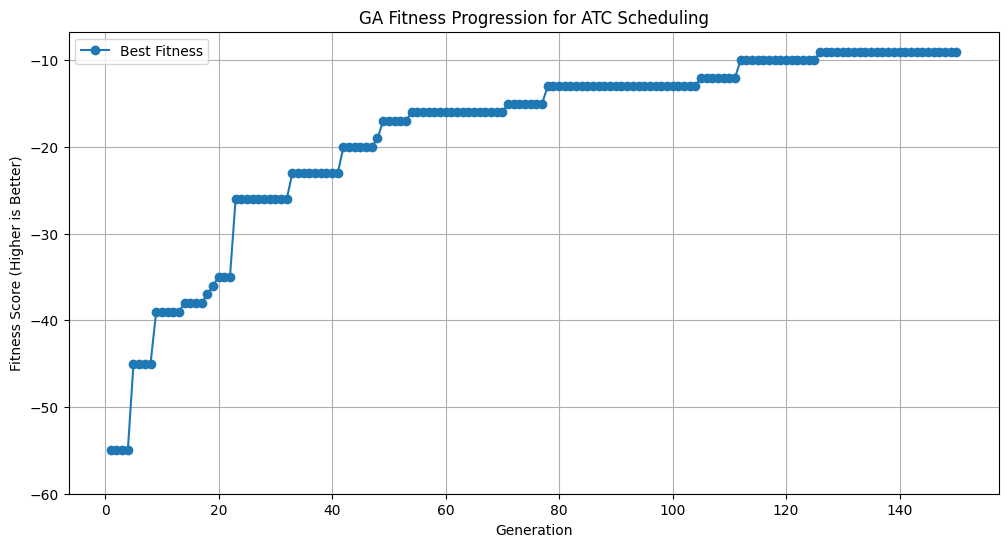

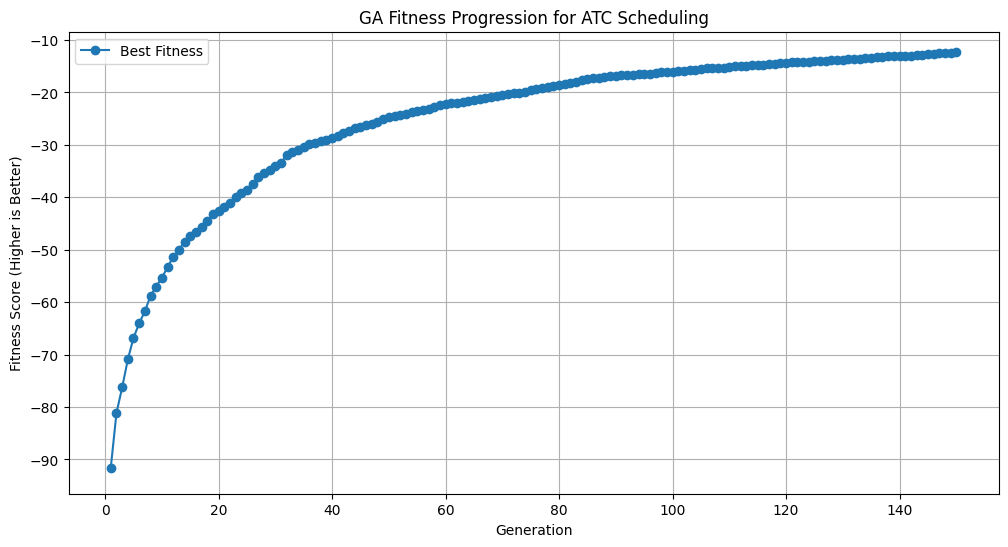

In [13]:
best_schedule, best_fitness, history, avg_history = genetic_algorithm(
        population_size=POPULATION_SIZE,
        num_people=NUM_PEOPLE,
        shifts_per_week=SHIFTS_PER_WEEK,
        shifts_per_day=SHIFTS_PER_DAY,
        days_per_week=DAYS_PER_WEEK,
        generations=GENERATIONS,
        mutation_rate=MUTATION_RATE,
        crossover_rate=CROSSOVER_RATE,
    ) # CHECK THE PARAMETERS!!!

print("\n" + "="*30)
print("      Best Schedule Found")
print("="*30)
if best_schedule:
    # Evaluate the final best schedule again to be certain of its fitness score
    final_check_fitness = evaluate_fitness(best_schedule, NUM_PEOPLE, SHIFTS_PER_WEEK, SHIFTS_PER_DAY)
    print_schedule(best_schedule, final_check_fitness)
    if abs(final_check_fitness - best_fitness) > 0.01:
            print(f"[Note] Final re-evaluated fitness {final_check_fitness:.2f} differs slightly from tracked fitness {best_fitness:.2f}")
else:
    print("\nNo suitable schedule found (best_schedule is None).")
    
# Explain and show the plot
print("\n" + "="*30)
print("      Fitness Plot Explanation")
print("="*30)
print("The plot shows the fitness score evolution over generations:")
print(" - 'Best Fitness': The fitness score of the absolute best schedule found in each generation.")
print(" - 'Average Fitness': The average fitness score of all schedules in the population for each generation.")
print("Ideally, both lines should trend upwards (towards 0 or positive values).")
print("The gap between average and best fitness indicates population diversity.")
plot_fitness(history)
plot_fitness(avg_history)

# Q2 Exploring the Solution Space (5 points)

Now that you've written a base genetic algorithm, let's see what additional information you can learn about this problem. Every air traffic controller gets paid the same amount regardless of how many shifts they work. Management wants to find the minimum number of air traffic controllers they need without creating ANY constraint violations.

a. Using your genetic algorithm solver, find the minimum number of air traffic controllers needed.

b. Describe how you came up with your answer to part A and how confident you are in that answer.

# Solution 2

First, I set the soft constraint penalty to 0 - we can easily fix a soft constraint violation by simply taking someone off of shift. Running my algorithm with 5 people a few times, the highest result I got was -4, pasted below:

```
Schedule (Fitness: -4.00):
      Sun | Mon | Tue | Wed | Thu | Fri | Sat
      M A N M A N M A N M A N M A N M A N M A N
      ----------------------------------------------
ATC 1: 101 000 010 010 000 010 100
ATC 2: 010 010 101 010 001 000 010
ATC 3: 000 100 010 010 100 000 001
ATC 4: 000 001 000 101 000 010 010
ATC 5: 010 010 010 100 010 101 000
----------------------------------------------------
```

Looking at the two violations, one is ATC 2 day 4, where they work the day after a night shift. There are already two other controllers on this shift so it'd be trivial to simply give them that day off. The other is day 5 afternoon shift, which only has ATC5 scheduled. ATCs 2 and 3 work the morning and night shifts of that day, and ATC4 just worked a night shift, but ATC1 is free to work that shift, so we have created a constraint abiding solution with 5 workers.

If we reduce that to 4, however, the situation changes. On a given midweek day, there are 4 controllers, and 4 shifts to be filled. However, one of the controllers must have worked the previous night shift, and thus is ineligible to work that day, so really, we are down to three controllers. One of these must the morning shift, meaning the other two must take the afternoon shift. The other two must then go off duty, so ATC1 comes back for a night shift.

This would look like
```
ATC 1: 101
ATC 2: 010
ATC 3: 010
ATC 4: 000 (let's say ATC4 worked the last night shift)
```
On the next day, we simply rotate all the roles over by one, so that whoever previously worked the night shift now gets the day off
```
ATC 1: 101 000
ATC 2: 010 101
ATC 3: 010 010
ATC 4: 000 010
```
And so on. So therefore, 4 people is difficult but achievable. At 3 people, howevert this fully breaks down. Keeping in mind one person is ineligible due to the night shift, we must now cover the whole day with only 2 people. One of them takes the morning shift, making them now ineligible to do the afternoon shift. However, that shift requires two people to run and we only have one left. Therefore, we can claim with relative confidence that 4 is the fewest number of required air traffic controllers.

# Q3 Tweaking the Parameters (10 points)

Now that you've written a base genetic algorithm, let's see if you can improve the performance by tweaking the parameters. Pick one of the GA Parameters and create a plot showing the results at different values.


      Best Schedule Found

Schedule (Fitness: -5.00):
      Sun | Mon | Tue | Wed | Thu | Fri | Sat
      M A N M A N M A N M A N M A N M A N M A N
      ----------------------------------------------
ATC 1: 010 000 101 000 000 000 010
ATC 2: 101 101 000 010 010 001 000
ATC 3: 010 010 000 101 000 010 000
ATC 4: 000 010 010 010 101 100 010
ATC 5: 000 010 010 000 010 010 101
----------------------------------------------------

      Fitness Plot Explanation
The plot shows the fitness score evolution over generations:
 - 'Best Fitness': The fitness score of the absolute best schedule found in each generation.
 - 'Average Fitness': The average fitness score of all schedules in the population for each generation.
Ideally, both lines should trend upwards (towards 0 or positive values).
The gap between average and best fitness indicates population diversity.


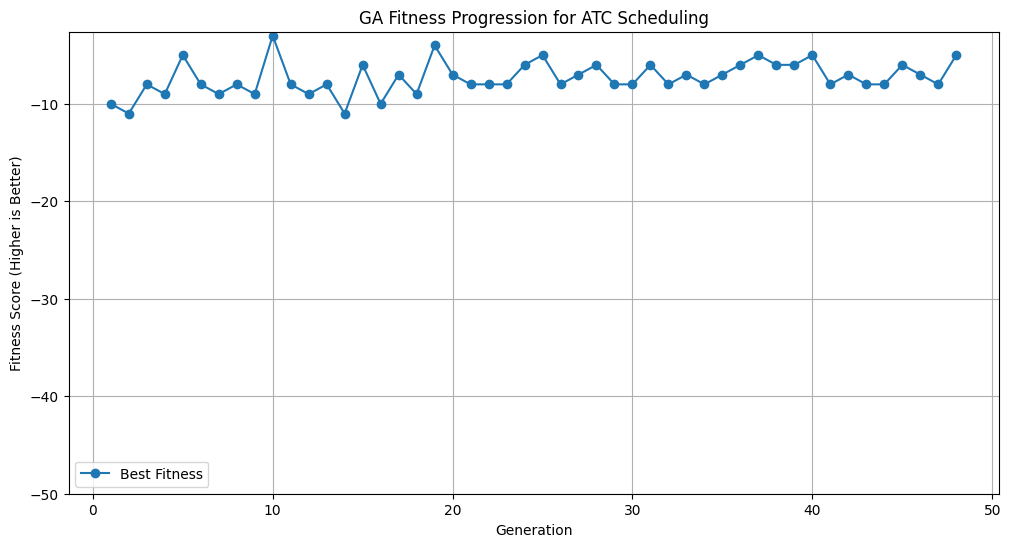

Max fitness across all runs -3


In [ ]:
bests = []
for size in range(50,1000,20):
    best_schedule, best_fitness, history, avg_history = genetic_algorithm(
            population_size=size, # parameter you could pick to sweep 
            num_people=NUM_PEOPLE,
            shifts_per_week=SHIFTS_PER_WEEK,
            shifts_per_day=SHIFTS_PER_DAY,
            days_per_week=DAYS_PER_WEEK,
            generations=GENERATIONS,
            mutation_rate=MUTATION_RATE, # parameter you could pick to sweep 
            crossover_rate=CROSSOVER_RATE, # parameter you could pick to sweep 
        )  # CHECK THE PARAMETERS!!!
    bests.append(best_fitness)



# CHANGE THIS CODE BELOW SO THAT IT PLOTS THE PARAMETER THAT GETS SWEEPED

print("\n" + "="*30)
print("      Best Schedule Found")
print("="*30)
if best_schedule:
    # Evaluate the final best schedule again to be certain of its fitness score
    final_check_fitness = evaluate_fitness(best_schedule, NUM_PEOPLE, SHIFTS_PER_WEEK, SHIFTS_PER_DAY)
    print_schedule(best_schedule, final_check_fitness)
    if abs(final_check_fitness - best_fitness) > 0.01:
            print(f"[Note] Final re-evaluated fitness {final_check_fitness:.2f} differs slightly from tracked fitness {best_fitness:.2f}")
else:
    print("\nNo suitable schedule found (best_schedule is None).")
# Explain and show the plot
print("\n" + "="*30)
print("      Fitness Plot Explanation")
print("="*30)
print("The plot shows the fitness score evolution over generations:")
print(" - 'Best Fitness': The fitness score of the absolute best schedule found in each generation.")
print(" - 'Average Fitness': The average fitness score of all schedules in the population for each generation.")
print("Ideally, both lines should trend upwards (towards 0 or positive values).")
print("The gap between average and best fitness indicates population diversity.")
print(f"Max fitness across all runs {max(bests)}")

max fitness: 230, -3
Line Slope: 0.00220907511940947


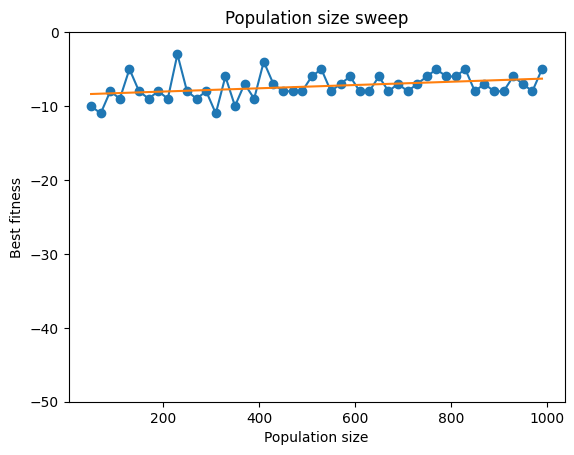

In [46]:
plt.figure()
X = np.array(range(50,1000,20))
plt.scatter(X, bests)
plt.plot(X, bests)

besti, best = max(enumerate(bests), key=lambda x: x[1])
print(f"max fitness: {X[besti]}, {best}")

m, b = np.polyfit(X, bests, 1)
plt.plot(X, X*m+b)
print(f"Line Slope: {m}")


plt.title("Population size sweep")
plt.xlabel("Population size")
plt.ylabel("Best fitness")
plt.ylim([-50,0])
plt.show()

### Interpret

- What parameter did you pick?

- What was optimal value for that parameter and why?

- Is there another parameter do you think that tweaking it's value will improve the results and why?

# Solution 3

- I chose to sweep the population size
-  Our greatest run happened when the population size was 230, and the fitness was -3. I'm not quite sure exactly why - I'd expect that a larger population size would be better for the same number of generations, since we give better mutations and crossovers more opportunities to occur, and a line of best fit would seem to indiicate a slight increase in fitness as the population went up, but there is some variance in the data that far outweights this slight trend.
-  I'd imagine there exists an optimal mutation rate that we may or may not be at right now - we want a good balance between allowing new mutations to be introduced into our gene pool without introducing so much chaos that they can't stick around

## Q4 Changing Core Operations (15 points)

Finally, we are going to explore other methods for selection, crossover, and mutation. Choose your parent selection, mutation, crossover, or selection function and rewrite it to use a different method. Then, rerun the genetic algorithm and compare the results. Display the comparisons in a graph and interpret the results. You will do this twice; you can pick two different functions or pick the same function and come up with two different versions of it.

Completely optional, but if you are look for some inspiration this paper outlines the success of different kind of selection schemes: [A Comparative Analysis of Selection Schemes
Used in Genetic Algorithms](https://www.cse.unr.edu/~sushil/class/gas/papers/Select.pdf)

- Step/Method you are replacing: One point crossover

- Step/Method you are replacing it with: Multipoint crossover

- Interpret the results of this replacement: This seems to have little to no effect; the runs still seem to be within -5 to -10 fitness, and the multipoint crossover doesn't seem to converge on its solution much earlier than the one point variant



      Best Schedule Found

Schedule (Fitness: -9.00):
      Sun | Mon | Tue | Wed | Thu | Fri | Sat
      M A N M A N M A N M A N M A N M A N M A N
      ----------------------------------------------
ATC 1: 000 001 000 101 000 010 000
ATC 2: 001 010 011 000 100 100 010
ATC 3: 000 000 100 010 001 000 010
ATC 4: 010 100 000 000 010 010 101
ATC 5: 010 010 010 010 010 001 100
----------------------------------------------------

      Fitness Plot


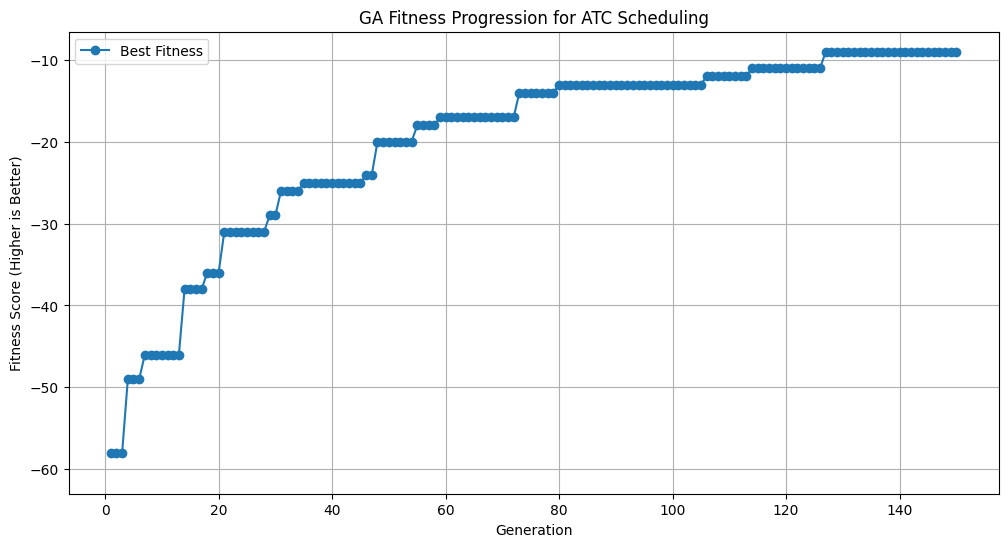

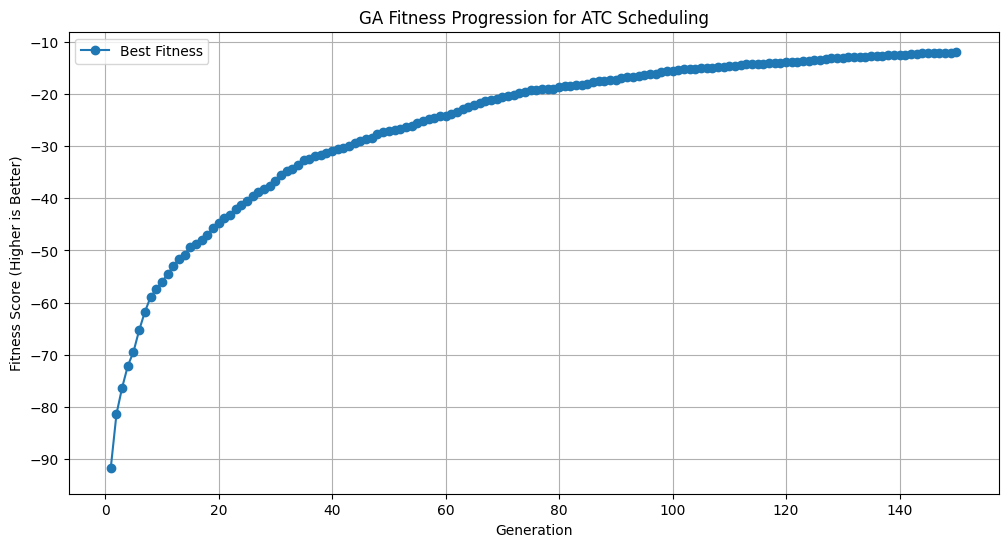

In [62]:
def mp_crossover(parent_1, parent_2, shifts_per_week, crossover_rate):
    child_1 = parent_1
    child_2 = parent_2
    if random.random() <= crossover_rate:
        num_crosses = random.randint(1,4)
        crossover_points = sorted([random.randint(0, shifts_per_week-1) for _ in range(num_crosses)])
        child_1_crossed = child_1
        child_2_crossed = child_2
        for cp in crossover_points:
            child_1_crossed = child_1_crossed[:cp] + child_2_crossed[cp:]
            child_2_crossed = child_2_crossed[:cp] + child_1_crossed[cp:]
        return child_1_crossed, child_2_crossed
    else:
        return child_1, child_2

def verison_2(population_size, num_people, shifts_per_week, shifts_per_day, days_per_week,
                      generations, mutation_rate, crossover_rate):    #replace with the name of the function
    population = generate_population(population_size, num_people, shifts_per_week)
    history = list()
    avg_history = list()
    for _ in range(generations):
        # select parents
        fitness_scores = [evaluate_fitness(x, num_people, shifts_per_week, shifts_per_day) for x in population]
        history.append(max(fitness_scores))
        avg_history.append(sum(fitness_scores) / len(fitness_scores))
        num_parents = int(0.6 * population_size)
        parents = parent_selection(population, fitness_scores, num_parents)

        # reproduce
        children = []
        for i in range(num_parents // 2):
            parent_1, parent_2 = parents[i], parents[i+1]
            child_1, child_2 = mp_crossover(parent_1, parent_2, shifts_per_week, crossover_rate)
            child_1 = mutate(child_1, mutation_rate)
            child_2 = mutate(child_2, mutation_rate)
            children += [child_1, child_2]

        # pick the best 100 for next population
        population = select_survivors(population, children, population_size, num_people, shifts_per_week, shifts_per_day, days_per_week)
    
    best =  max(population, key=lambda x: evaluate_fitness(x, num_people, shifts_per_week, shifts_per_day))
    best_fitness = evaluate_fitness(best, num_people, shifts_per_week, shifts_per_day)
    return best, best_fitness, history, avg_history


# Copy code above to run and plot this function
best_schedule, best_fitness, history, avg_history = verison_2(
    population_size=POPULATION_SIZE,
    num_people=NUM_PEOPLE,
    shifts_per_week=SHIFTS_PER_WEEK,
    shifts_per_day=SHIFTS_PER_DAY,
    days_per_week=DAYS_PER_WEEK,
    generations=GENERATIONS,
    mutation_rate=MUTATION_RATE,
    crossover_rate=CROSSOVER_RATE,
) # CHECK THE PARAMETERS!!!

print("\n" + "="*30)
print("      Best Schedule Found")
print("="*30)
if best_schedule:
    # Evaluate the final best schedule again to be certain of its fitness score
    final_check_fitness = evaluate_fitness(best_schedule, NUM_PEOPLE, SHIFTS_PER_WEEK, SHIFTS_PER_DAY)
    print_schedule(best_schedule, final_check_fitness)
    if abs(final_check_fitness - best_fitness) > 0.01:
            print(f"[Note] Final re-evaluated fitness {final_check_fitness:.2f} differs slightly from tracked fitness {best_fitness:.2f}")
else:
    print("\nNo suitable schedule found (best_schedule is None).")
    
# Explain and show the plot
print("\n" + "="*30)
print("      Fitness Plot")
print("="*30)
plot_fitness(history)
plot_fitness(avg_history)

- Step/Method you are replacing: Roulette Wheel Parent Selection

- Step/Method you are replacing it with: Elitism

- Interpret the results of this replacement: Curiosuly, elitism completely broke the algorithm - the results are completely all the place. I knew elitism could have a negative effect because of how quickly it can homogenize the population, but I wasn't expecting effects of such magnitude. Clearly, elitism leads to quick convergence (as evidenced when I looked at the runs which had many identical or near-identical solutions), but that power needs to be carefully managed so as to not totally wreak havoc



      Best Schedule Found

Schedule (Fitness: -87.00):
      Sun | Mon | Tue | Wed | Thu | Fri | Sat
      M A N M A N M A N M A N M A N M A N M A N
      ----------------------------------------------
ATC 1: 000 100 101 111 100 110 111
ATC 2: 111 000 100 111 101 010 100
ATC 3: 001 101 101 000 010 010 111
ATC 4: 101 001 101 101 101 000 001
ATC 5: 101 000 000 010 010 101 111
----------------------------------------------------

      Fitness Plot


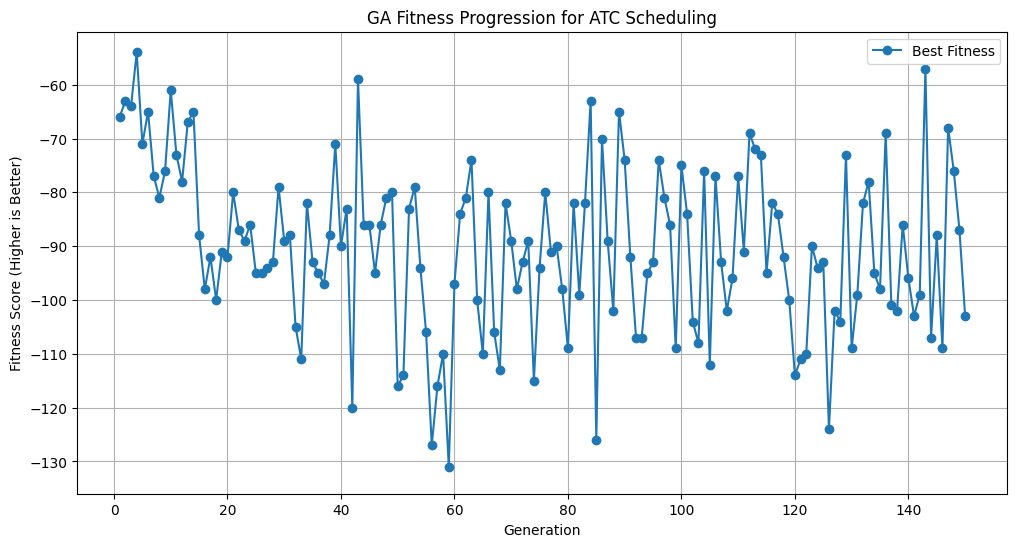

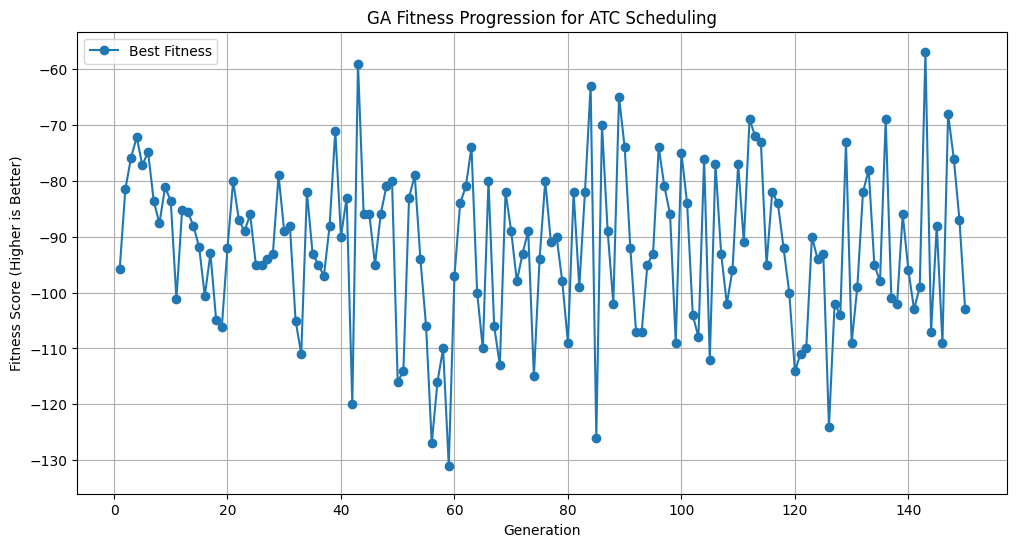

In [69]:
def parent_selection_elite(population, fitness_scores, num_parents):
    """
    Use elitism to select the best two parents by fitness score and breed them for the next generation
    
    Args:
        population (list): list of schedules in our population
        finess_scores (list): list of fitness scores for each schedule in our population
        num_parents (int): how many parents to select
    """
    sorted_pop = sorted(enumerate(population), key=lambda t: fitness_scores[t[0]], reverse=True)
    return list(x[1] for x in sorted_pop[:num_parents])

def version_3(population_size, num_people, shifts_per_week, shifts_per_day, days_per_week,
                      generations, mutation_rate, crossover_rate):    #replace with the name of the function
    population = generate_population(population_size, num_people, shifts_per_week)
    history = list()
    avg_history = list()
    for _ in range(generations):
        # select parents
        fitness_scores = [evaluate_fitness(x, num_people, shifts_per_week, shifts_per_day) for x in population]
        history.append(max(fitness_scores))
        avg_history.append(sum(fitness_scores) / len(fitness_scores))
        num_parents = int(0.6 * population_size)
        parents = parent_selection_elite(population, fitness_scores, num_parents)

        # reproduce
        children = []
        for i in range(num_parents // 2):
            parent_1, parent_2 = parents[i], parents[i+1]
            child_1, child_2 = crossover(parent_1, parent_2, shifts_per_week, crossover_rate)
            child_1 = mutate(child_1, mutation_rate)
            child_2 = mutate(child_2, mutation_rate)
            children += [child_1, child_2]

        # pick the best 100 for next population
        population = select_survivors(population, children, population_size, num_people, shifts_per_week, shifts_per_day, days_per_week)
    
    best =  max(population, key=lambda x: evaluate_fitness(x, num_people, shifts_per_week, shifts_per_day))
    best_fitness = evaluate_fitness(best, num_people, shifts_per_week, shifts_per_day)
    return best, best_fitness, history, avg_history


# Copy code above to run and plot this function
best_schedule, best_fitness, history, avg_history = version_3(
    population_size=POPULATION_SIZE,
    num_people=NUM_PEOPLE,
    shifts_per_week=SHIFTS_PER_WEEK,
    shifts_per_day=SHIFTS_PER_DAY,
    days_per_week=DAYS_PER_WEEK,
    generations=GENERATIONS,
    mutation_rate=MUTATION_RATE,
    crossover_rate=CROSSOVER_RATE,
) # CHECK THE PARAMETERS!!!

print("\n" + "="*30)
print("      Best Schedule Found")
print("="*30)
if best_schedule:
    # Evaluate the final best schedule again to be certain of its fitness score
    final_check_fitness = evaluate_fitness(best_schedule, NUM_PEOPLE, SHIFTS_PER_WEEK, SHIFTS_PER_DAY)
    print_schedule(best_schedule, final_check_fitness)
    if abs(final_check_fitness - best_fitness) > 0.01:
            print(f"[Note] Final re-evaluated fitness {final_check_fitness:.2f} differs slightly from tracked fitness {best_fitness:.2f}")
else:
    print("\nNo suitable schedule found (best_schedule is None).")
    
# Explain and show the plot
print("\n" + "="*30)
print("      Fitness Plot")
print("="*30)
plot_fitness(history)
plot_fitness(avg_history)

# Copy code above to run and plot this function